Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1684 files belonging to 2 classes.
Class names: ['Non-standard', 'Standard']


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         131,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,718,978 (90.48 MB)

 Trainable params: 131,266 (512.76 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

Epoch 1/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 447s 5s/step - accuracy: 0.6966 - loss: 0.8100 - val_accuracy: 0.8250 - val_loss: 0.3811
Epoch 2/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 357s 4s/step - accuracy: 0.8482 - loss: 0.3482 - val_accuracy: 0.8625 - val_loss: 0.3425
Epoch 3/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 359s 4s/step - accuracy: 0.8722 - loss: 0.3291 - val_accuracy: 0.9000 - val_loss: 0.2636
Epoch 4/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 349s 4s/step - accuracy: 0.8715 - loss: 0.3129 - val_accuracy: 0.8750 - val_loss: 0.3396
Epoch 5/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 352s 4s/step - accuracy: 0.8783 - loss: 0.2925 - val_accuracy: 0.9125 - val_loss: 0.2977
Epoch 6/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 409s 5s/step - accuracy: 0.8961 - loss: 0.2720 - val_accuracy: 0.8562 - val_loss: 0.3155
Epoch 7/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 353s 4s/step - accuracy: 0.8743 - loss: 0.2854 - val_accuracy: 0.9000 - val_loss: 0.2582
Epoch 8/10
84/84 ━━━━━━━━━━━━━━━━━━━━ 350s 4s/step - accuracy: 0.8791 - loss: 0.2718 - val_accuracy: 0.8125 - v

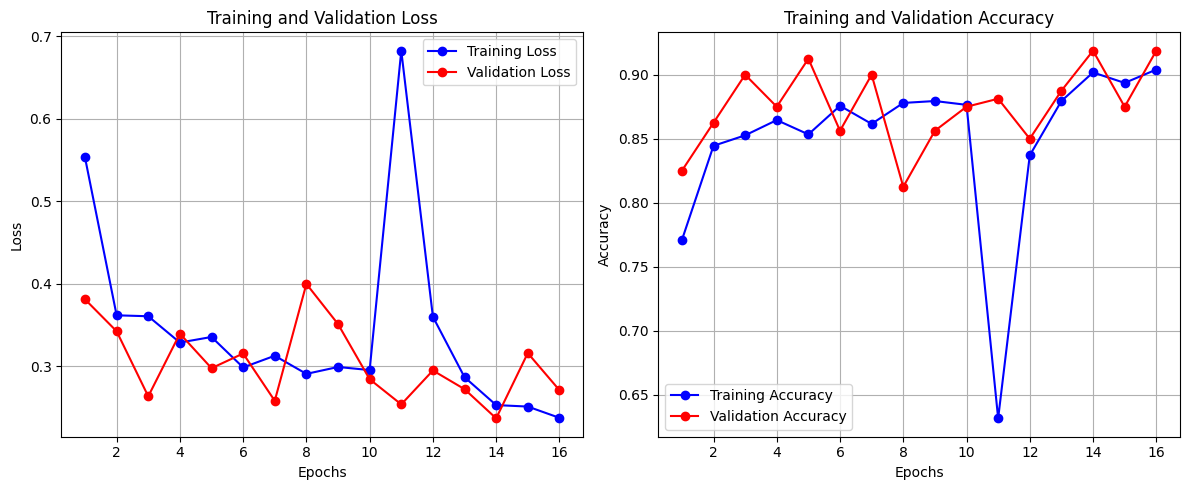

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Parameters
batch_size = 16
img_height = 224
img_width = 224
data_dir = '/content/drive/MyDrive/prenatal'

# Load dataset
dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    seed=123
)
class_names = dataset.class_names
print(f"Class names: {class_names}")

# Split dataset into train, val, test
train_size = 0.8
val_size = 0.1
test_size = 0.1

total_count = len(dataset)
train_count = int(total_count * train_size)
val_count = int(total_count * val_size)

train_ds = dataset.take(train_count)
val_ds = dataset.skip(train_count).take(val_count)
test_ds = dataset.skip(train_count + val_count)

# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
])

# Apply augmentation only on training data
train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

# Prefetch data for optimization
train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# Load ResNet50 as the base model
base_model = ResNet50(input_shape=(img_height, img_width, 3),
                      include_top=False,  # Exclude the classification head
                      weights='imagenet')  # Use pre-trained weights on ImageNet

# Freeze the base model layers to retain pre-trained weights
base_model.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  # Reduce feature maps to a single vector per image
    layers.Dense(64, activation='relu'),  # Additional dense layer
    layers.Dropout(0.2),  # Add dropout to reduce overfitting
    layers.Dense(len(class_names), activation='softmax')  # Classification layer
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

# Train the model
epochs = 10
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

# Unfreeze some base model layers for fine-tuning
base_model.trainable = True
fine_tune_at = 100  # Unfreeze layers after this point

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Re-compile the model for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Lower learning rate for fine-tuning
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
fine_tune_epochs = 5
total_epochs = epochs + fine_tune_epochs
history_fine = model.fit(train_ds, validation_data=val_ds, epochs=total_epochs, initial_epoch=history.epoch[-1])

# Evaluate the model
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.2f}")

# Predictions
y_true = []
y_pred = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot training and fine-tuning curves
def plot_training_curves(history, history_fine=None):
    # Extract data from history
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    if history_fine:
        loss += history_fine.history['loss']
        val_loss += history_fine.history['val_loss']
        accuracy += history_fine.history['accuracy']
        val_accuracy += history_fine.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot training and fine-tuning curves
plot_training_curves(history, history_fine)


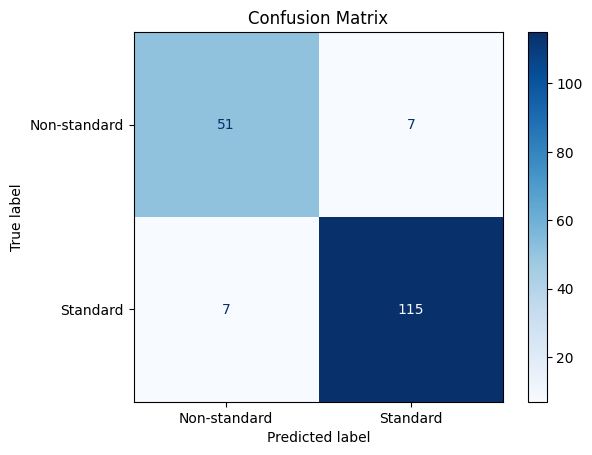

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, class_names):
    """
    Plots a confusion matrix using sklearn's ConfusionMatrixDisplay.

    Parameters:
    - y_true: List of true labels.
    - y_pred: List of predicted labels.
    - class_names: List of class names for the dataset.
    """
    # Generate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

# Example Usage
# Assuming y_true and y_pred are defined, and class_names is a list of your class names
plot_confusion_matrix(y_true, y_pred, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


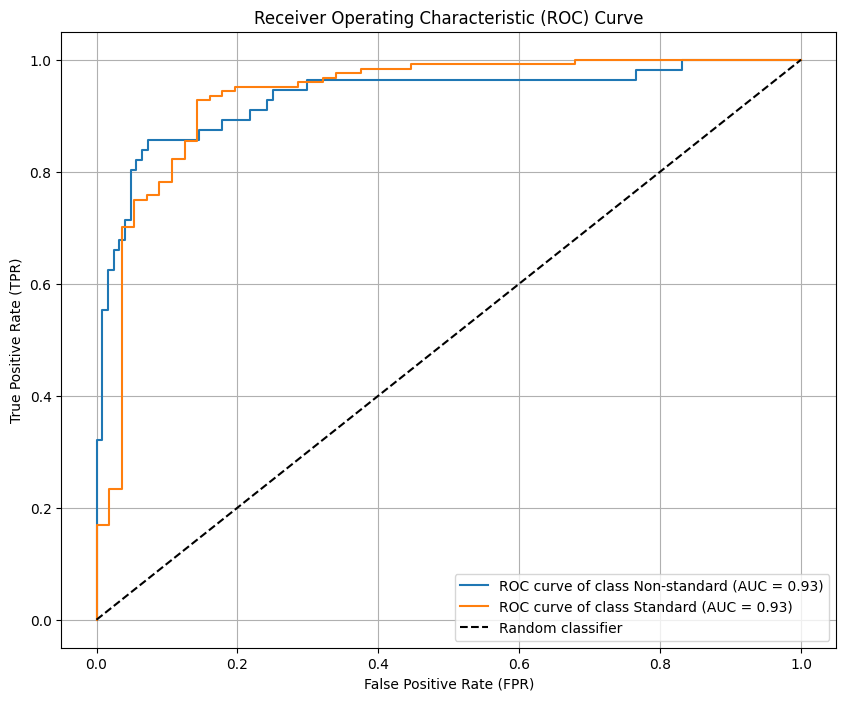

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Predictions (use probability scores instead of class labels)
y_true = []
y_pred_prob = []  # Predicted probabilities for each class

# Get the true labels and predicted probabilities
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    preds = model.predict(images)
    y_pred_prob.extend(preds)  # Store predicted probabilities for ROC curve

y_true = np.array(y_true)
y_pred_prob = np.array(y_pred_prob)

# Compute ROC curve and AUC for each class
fpr = {}
tpr = {}
roc_auc = {}

for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_prob[:, i])  # One-vs-rest for each class
    roc_auc[i] = auc(fpr[i], tpr[i])  # Compute the AUC for the class

# Plot all ROC curves
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_names[i]} (AUC = {roc_auc[i]:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random classifier')

plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
